# Install libraries 


In [1]:
import sys, os, json
import mne, sklearn, wandb
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from nilearn import datasets, image, masking, plotting
from nilearn.input_data import NiftiLabelsMasker
from tqdm import tqdm

# animation part
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
# from celluloid import Camera   # it is convinient method to animate
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation


## torch libraries 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, Subset

from pytorch_model_summary import summary


/home/user/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
%load_ext autoreload
%autoreload 2
sys.path.insert(1, os.path.realpath(os.path.pardir))

from utils import get_datasets
from utils import preproc
from utils import torch_dataset
from utils import train_utils
from utils import inference
from utils.models_arch import autoencoder_v3
from utils.models_arch import simple_models

# Set all hyperparameters
- Cuda and GPU.
- Parameters of dataset. 
- random seed( if necessary). 


In [3]:
print(torch.cuda.is_available(), torch.cuda.device_count())
torch.cuda.set_device(1)

True 4


In [4]:
config = dict(  
                dataset_name = 'CWL',
                fps = 250,
                new_fps=250, 
                n_channels = 30,
                n_roi = 21,
                test_sec = 60, # in seconds.
                freqs = np.linspace(2, 100, 16), 
                
                
                bold_delay = 0,
                to_many = False,
                random_subsample = False,
                sample_per_epoch = None, 
                WINDOW_SIZE = 250*16,
                    
                optimizer=None,
                lr=None,
                weight_decay=None, 
                batch_size=None, 

                loss_function = 'mse', 
                model_type = 'Ridge_Linear_regression'
                )


hp_model = dict(alpha=10000,  # parameter of L2
                inp_stride=256, # additional downsampling for Linear Model
                step = 25 # we can not terain on all train data. 
               )


config = {**hp_model, **config}

params_train = {'batch_size': config['batch_size'],
                'shuffle': True,
                'num_workers': 0}

params_val = {'batch_size': config['batch_size'],
              'shuffle': False}

# Upload preprocessed dataset from np files. 
It should accelerate speed of experiments.

In [5]:
with open("labels_roi.json", 'r') as f:
    labels_roi = json.load(f)


if config['dataset_name']=='CWL':
    dataset_path = '../data/dataset_cwl_250_hz.npz'
    
elif config['dataset_name']=='NODDI':
    dataset_path = '../data/dataset_NODDI_250_hz.npz'
else:
    print('no such dataset')

data = np.load(dataset_path)
train_dataset_prep = (data['x_train'], data['y_train'])
test_dataset_prep = (data['x_test'], data['y_test'])



# apply time dealy corrected
train_dataset_prep = preproc.bold_time_delay_align(train_dataset_prep, 
                                                   config['new_fps'],
                                                   config['bold_delay'])
test_dataset_prep = preproc.bold_time_delay_align(test_dataset_prep, 
                                                  config['new_fps'],
                                                  config['bold_delay'])


print('Size of train dataset:', train_dataset_prep[0].shape, train_dataset_prep[1].shape)
print('Size of test dataset:', test_dataset_prep[0].shape, test_dataset_prep[1].shape)

# torch dataset creation 

torch_dataset_train = torch_dataset.CreateDataset_eeg_fmri(train_dataset_prep, 
                                                            window_size = config['WINDOW_SIZE'])

torch_dataset_test = torch_dataset.CreateDataset_eeg_fmri(test_dataset_prep,  
                                                           window_size =config['WINDOW_SIZE'])


Size of train dataset: (30, 16, 54225) (21, 54225)
Size of test dataset: (30, 16, 15000) (21, 15000)


In [6]:
x_train, y_train = torch_dataset_train.get_full_dataset(inp_stride=config['inp_stride'], 
                                                        step=config['step'])
x_test, y_test = torch_dataset_test.get_full_dataset(inp_stride=config['inp_stride'], 
                                                     step=1)


dataset_train = (x_train.reshape(len(x_train), -1) , y_train)
dataset_test = (x_test.reshape(len(x_test), -1), y_test)

print('Sizes before', x_train.shape, y_train.shape)
print('Sizes before', x_test.shape, y_test.shape)

print('sizes of datasets:',dataset_train[0].shape, dataset_train[1].shape) 

100%|██████████| 10999/10999 [00:00<00:00, 130883.84it/s]


Sizes before (2009, 30, 16, 16) (2009, 21)
Sizes before (10999, 30, 16, 16) (10999, 21)
sizes of datasets: (2009, 7680) (2009, 21)


# Init Model, Loss, optimizers

10000


100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


Results for Linear model 10000


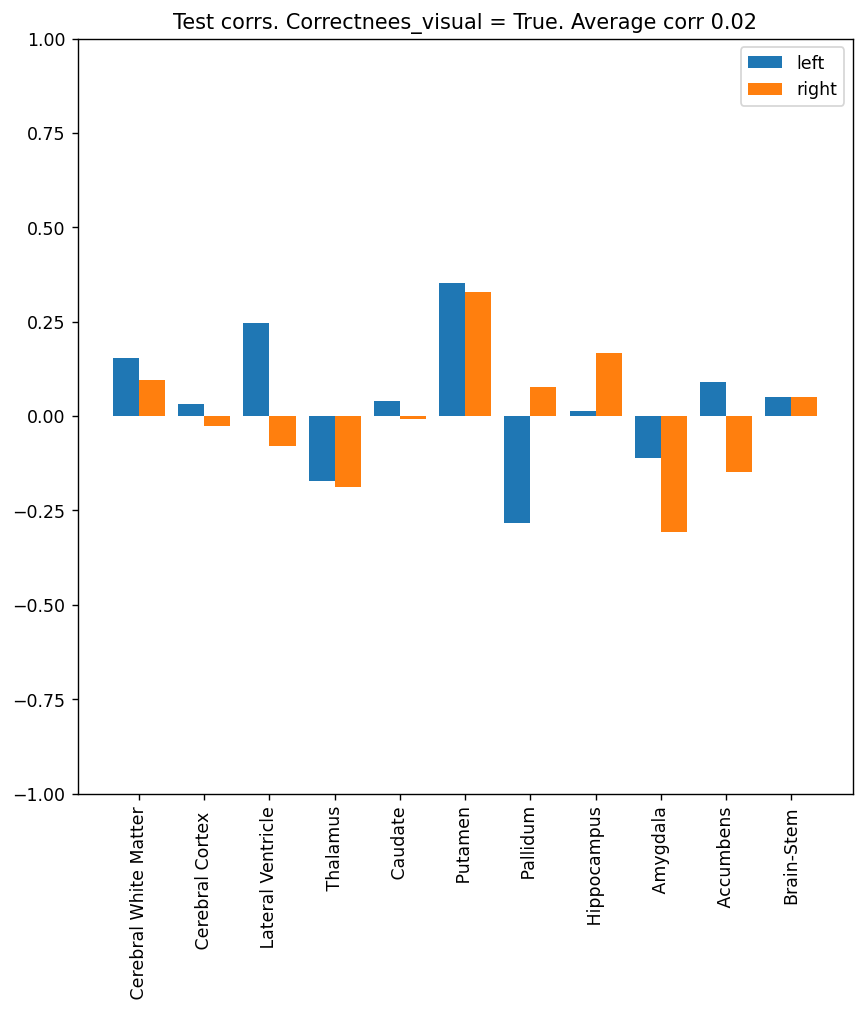

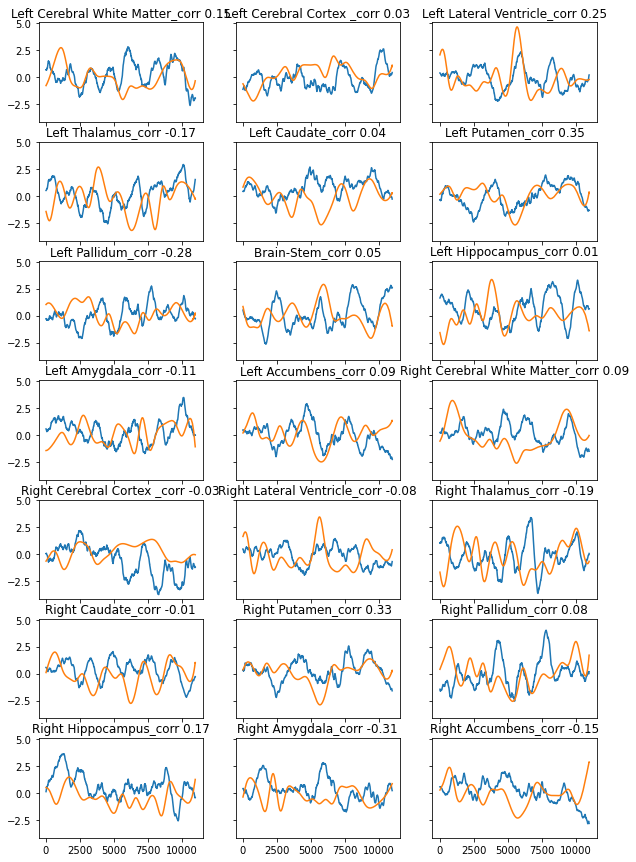

In [7]:
# init model
ridge_model_func = simple_models.get_Ridge_init_func(config['alpha'])

# fit model
roi_models, corr_train, corr_test, y_hats = simple_models.train_simple_model(ridge_model_func, 
                                                               dataset_train,
                                                               dataset_test)

# visaulization
inference.corr_results_plot(labels_roi, corr_test)
inference.make_visualization(y_prediction=y_hats,
                             y_test=dataset_test[1].T, 
                             labels=labels_roi)

print('Results for Linear model', config['alpha'])

(<Figure size 720x1080 with 21 Axes>,
 [0.15417428869648475,
  0.032229373572918024,
  0.24622543910841937,
  -0.17145080786702127,
  0.03992631846190444,
  0.3516578364351236,
  -0.2821230325933086,
  0.05112663832146452,
  0.012892961205546699,
  -0.1109743903972732,
  0.08922735095406506,
  0.094368087237596,
  -0.025749167915713033,
  -0.07941346410414299,
  -0.18810761220872232,
  -0.007414655097714424,
  0.3281111317395186,
  0.07767606795245516,
  0.1679207389852278,
  -0.30731291290439566,
  -0.14885438021589875])

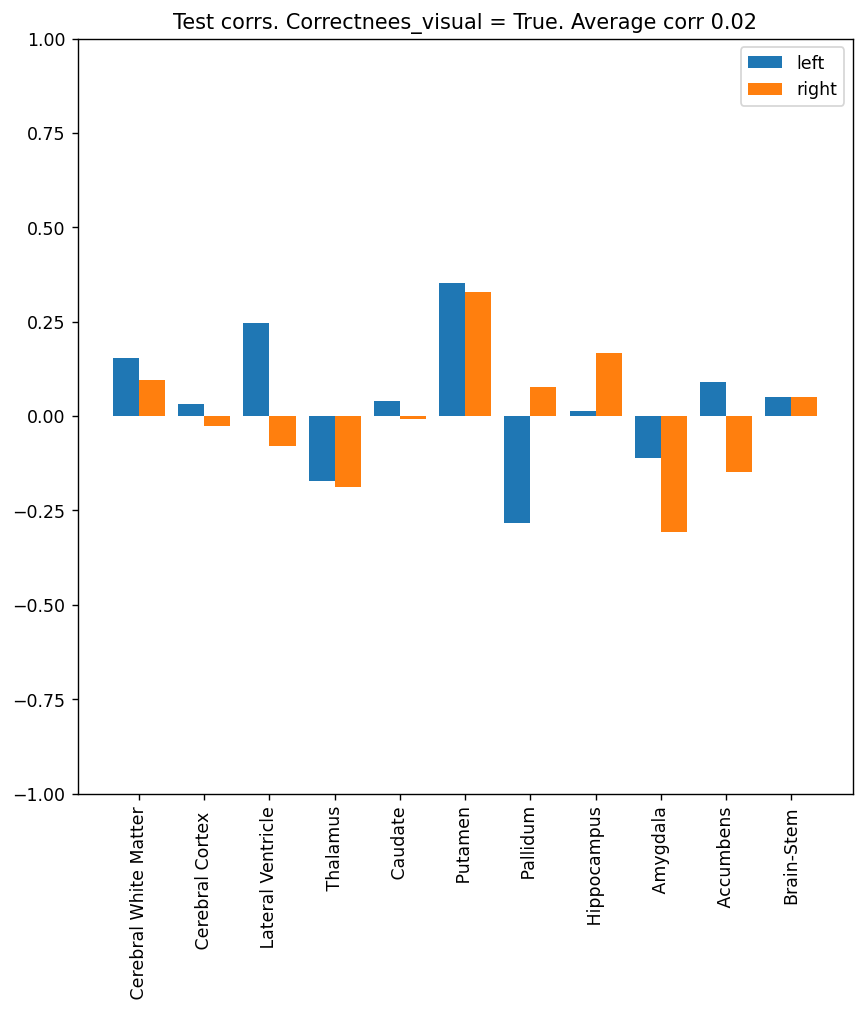

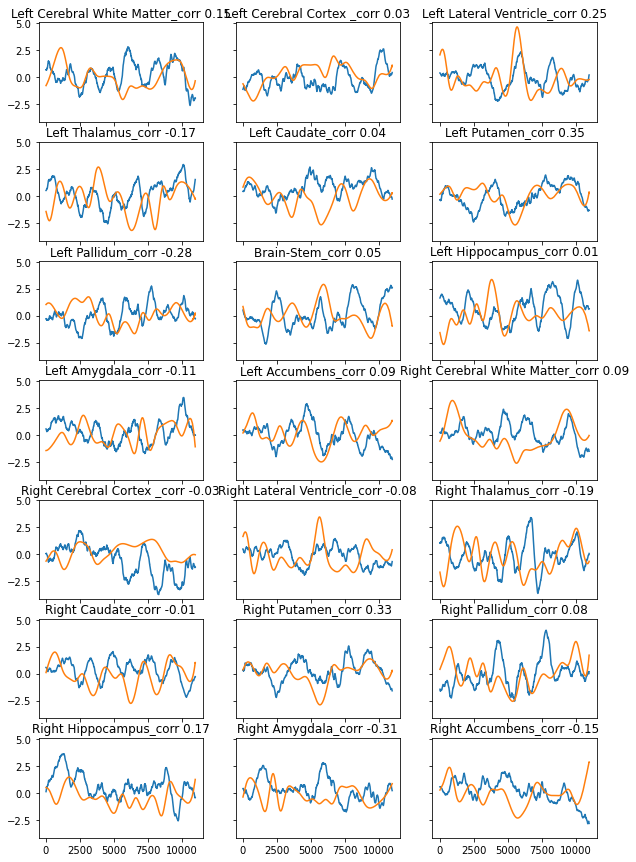

In [8]:
inference.corr_results_plot(labels_roi, corr_test)
inference.make_visualization(y_prediction=y_hats,
                             y_test=dataset_test[1].T, 
                             labels=labels_roi)